# LeNet-5 - An introduction and overview

Perhaps the first widely known and successful application of convolutional neural networks was **LeNet-5**, described by Yann LeCun, et al. in their 1998 paper titled [Gradient-Based Learning Applied to Document Recognition](https://ieeexplore.ieee.org/document/726791). The system was developed for use in a handwritten character recognition problem and demonstrated on the **MNIST standard dataset**, achieving approximately 99.2% classification accuracy (or a 0.8% error rate). The network was then described as the central technique in a broader system referred to as **Graph Transformer Networks**.

It is a long paper, and perhaps the best part to focus on is Section II. B. that describes the LeNet-5 architecture. In that section, the paper describes the network as having **seven layers** with input **grayscale images** having the **shape 32 x 32**, the size of images in the MNIST dataset.



```
The model proposes a pattern of a convolutional layer followed by an average pooling layer, referred to as a subsampling layer.
```



This pattern is repeated two and a half times before the output feature maps are flattened and fed to some fully connected layers for interpretation and a final prediction. A picture of the network architecture is provided in the paper and reproduced below.

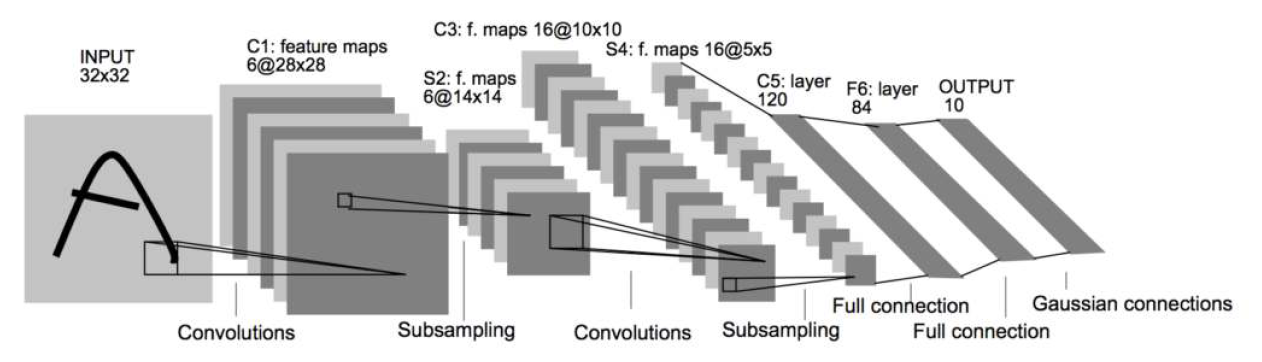

The pattern of blocks of convolutional layers and pooling layers (referred to as ***subsampling***) ***grouped*** and ***repeated*** **remains a typical pattern in designing and using convolutional neural networks today, more than twenty years later**. Interestingly, the architecture uses a small number of filters with a modest size as the first hidden layer, specifically 6 filters, each with 5x5 pixels. After pooling, another convolutional layer has many more filters, again with the same size, precisely 16 filters with 5x5 pixels, again followed by pooling. In the repetition of these two blocks of convolution and pooling layers, the trend increases the number of filters.

Compared to modern applications, the number of filters is also small, but **the trend of increasing the number of filters with the depth of the network also remains a common pattern in modern usage of the technique.** The flattening of the feature maps and interpretation and classification of the extracted features by fully connected layers also remains a common pattern today.



```
In modern terminology, the final section of the architecture is often referred to as the classifier, whereas the convolutional and 
pooling layers earlier in the model are referred to as the feature extractor.

```



We can summarize the key aspects of the architecture relevant in modern models as follows:



*   Fixed-sized input images.
*   Group convolutional and pooling layers into blocks.
*   Repetition of convolutional-pooling blocks in the architecture.
*   Increase in the number of filters with the depth of the network.
*   Distinct feature extraction and classifier parts of the architecture.

# Implementing LeNet-5

We'll be implementing the LeNet using W&B to help in the process.

## Step 01: Setup

Start out by installing the experiment tracking library and setting up your free W&B account:



*   **pip install wandb** – Install the W&B library
*   **import wandb** – Import the wandb library
*   **wandb login** – Login to your W&B account so you can log all your metrics in one place



In [ ]:
!pip install wandb -qU

     |████████████████████████████████| 1.9 MB 6.6 MB/s 
     |████████████████████████████████| 166 kB 59.7 MB/s 
     |████████████████████████████████| 182 kB 51.4 MB/s 
     |████████████████████████████████| 63 kB 1.0 MB/s 
     |████████████████████████████████| 166 kB 51.2 MB/s 
     |████████████████████████████████| 162 kB 67.0 MB/s 
     |████████████████████████████████| 162 kB 69.7 MB/s 
     |████████████████████████████████| 158 kB 44.4 MB/s 
     |████████████████████████████████| 157 kB 45.7 MB/s 
     |████████████████████████████████| 157 kB 56.8 MB/s 
     |████████████████████████████████| 157 kB 57.5 MB/s 
     |████████████████████████████████| 157 kB 34.5 MB/s 
     |████████████████████████████████| 157 kB 24.5 MB/s 
     |████████████████████████████████| 157 kB 19.5 MB/s 
     |████████████████████████████████| 157 kB 31.6 MB/s 
     |████████████████████████████████| 156 kB 46.9 MB/s 


Lets install CodeCabor: A Python package for tracking the carbon emissions produced by various kinds of computer programs, from straightforward algorithms to deep neural networks.


In [ ]:
!pip install codecarbon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 174 kB 4.1 MB/s 
     |████████████████████████████████| 66 kB 4.5 MB/s 
     |████████████████████████████████| 46 kB 3.3 MB/s 


###  Import Packages and Connecting to W&B

Import the necessary packages

In [ ]:
import logging
import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.datasets import mnist
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
from codecarbon import EmissionsTracker
from tensorflow.keras.callbacks import Callback
from wandb.keras import WandbCallback
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import wandb
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

### Configure logging

Reference for a logging object

In [ ]:
logger = logging.getLogger()

Set level of logging

In [ ]:
logger.setLevel(logging.INFO)

Creating handlers

In [ ]:
c_handler = logging.StreamHandler()
c_format = logging.Formatter(fmt="%(asctime)s %(message)s",datefmt='%d-%m-%Y %H:%M:%S')
c_handler.setFormatter(c_format)

Add handlers to the logger

In [ ]:
logger.handlers[0] = c_handler

## Step 02: Implementing

As we saw before that's basically the architecture of the LeNet we'll implement:



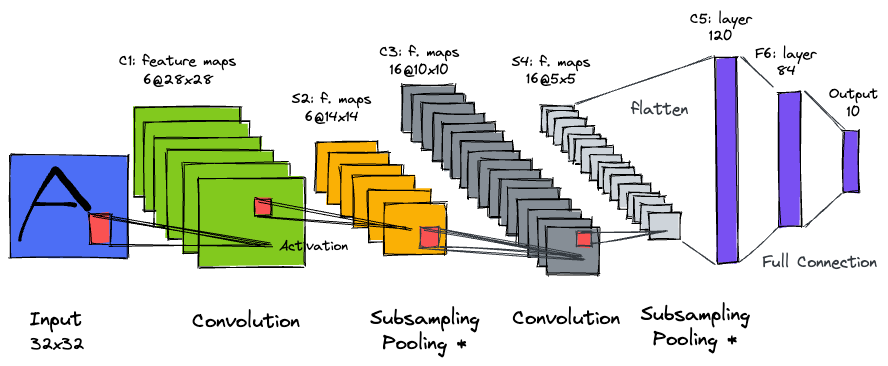

Source code based on **[Rosebrock, Adrian. Deep Learning For Computer vision with Python, 2019](https://pyimagesearch.com/deep-learning-computer-vision-python-book/)** 

In [ ]:
class LeNet:
  ''' 
  # create LeNet-5 model
  #
  # it is composed of the 8 layers (5 layers considering FC as one layer) 
  # such as:
  #      - 2 convolutional layers
  #      - 2 subsampling (avg pooling) layers
  #      - 1 flatten layer
  #      - 2 fully connected layers
  #      - 1 output layer with 10 outputs
  '''
  @staticmethod
  def build(width, height, depth, classes):
    # initialize the model
    model = Sequential()
    inputShape = (height, width, depth)
    
    # if we are using "channels first", update the input shape
    if K.image_data_format() == "channels_first":
      inputShape = (depth, height, width)
   
    # first set of CONV => TANH => POOL layers
    model.add(Conv2D(6, (5,5), strides=1, padding='same',
                     activation='tanh', input_shape=(28,28,1), )) #C1
    model.add(AveragePooling2D()) #S2

    # second set of CONV => TANH => POOL layers
    model.add(Conv2D(16, (5,5), strides=1, padding='valid',
                     activation='tanh')) #C3
    model.add(AveragePooling2D()) #S4

    # a flatten and two set of FC => TANH layers
    model.add(Flatten()) #Flatten
    model.add(Dense(120, activation='tanh')) #C5
    model.add(Dense(84, activation='tanh')) #F6

    # softmax classifier
    model.add(Dense(10, activation='softmax')) #Output layer
    
    # return the constructed network architecture
    return model

In [ ]:
# create a model object
model = LeNet.build(28,28,1,10)

In [ ]:
# summarize layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 5, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 120)               4

## Step 03: LeNet-5 on MNIST

### Fetch, Preprocessing and Data Segregation

Since we are using Jupyter Notebooks we can replace our argument
parsing code with *hard coded* arguments and values

In [ ]:
args = {
  "project_name": "lenet-5"
}

Open the W&B project

In [ ]:
run = wandb.init(entity="euripedes",
                 project=args["project_name"], 
                 job_type="Train")

wandb: Currently logged in as: euripedes. Use `wandb login --relogin` to force relogin


Grab the MNIST dataset (if this is your first time using this dataset then the 11MB download may take a few seconds)

In [ ]:
logger.info("[INFO] accessing MNIST...")
((train_x, train_y), (test_x, test_y)) = mnist.load_data()

logger.info("Train x: {}".format(train_x.shape))
logger.info("Train y: {}".format(train_y.shape))
logger.info("Test x: {}".format(test_x.shape))
logger.info("Test y: {}".format(test_y.shape))

03-11-2022 01:10:44 [INFO] accessing MNIST...


11490434/11490434 [==============================] - 0s 0us/step


03-11-2022 01:10:45 Train x: (60000, 28, 28)
03-11-2022 01:10:45 Train y: (60000,)
03-11-2022 01:10:45 Test x: (10000, 28, 28)
03-11-2022 01:10:45 Test y: (10000,)


Dealing with the channels order:

In [ ]:
# if we are using "channels first" ordering, then reshape the
# design matrix such that the matrix is:
# num_samples x depth x rows x columns
if K.image_data_format() == "channels_first":
	train_x = train_x.reshape((train_x.shape[0], 1, 28, 28))
	test_x = test_x.reshape((test_x.shape[0], 1, 28, 28))
 
# otherwise, we are using "channels last" ordering, so the design
# matrix shape should be: num_samples x rows x columns x depth
else:
	train_x = train_x.reshape((train_x.shape[0], 28, 28, 1))
	test_x = test_x.reshape((test_x.shape[0], 28, 28, 1))

In [ ]:
logger.info("Train x: {}".format(train_x.shape))
logger.info("Train y: {}".format(train_y.shape))
logger.info("Test x: {}".format(test_x.shape))
logger.info("Test y: {}".format(test_y.shape))

03-11-2022 00:14:10 Train x: (60000, 28, 28, 1)
03-11-2022 00:14:10 Train y: (60000,)
03-11-2022 00:14:10 Test x: (10000, 28, 28, 1)
03-11-2022 00:14:10 Test y: (10000,)


Scale data to the range of [0, 1]

In [ ]:
train_x = train_x.astype("float32") / 255.0
test_x = test_x.astype("float32") / 255.0

Convert the labels from integers to vectors

In [ ]:
lb = LabelBinarizer()
train_y = lb.fit_transform(train_y)
test_y = lb.transform(test_y)

### Training

In [ ]:
# create codecarbon tracker
# codecarbon is too much verbose, change the log level for more info
tracker = EmissionsTracker(log_level="critical")
tracker.start()

# initialize the optimizer and model
logger.info("[INFO] compiling model...")
opt = Adam(learning_rate=0.01)
model = LeNet.build(width=28, height=28, depth=1, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])

# train the network
logger.info("[INFO] training network...")
history = model.fit(train_x, train_y,
              validation_data=(test_x, test_y),
              batch_size=32,
              epochs=20, 
              verbose=0,
              callbacks=[wandb.keras.WandbCallback(save_model=False,
                                                   compute_flops=True)])

# get co2 emissions from tracker
# "CO2 emission (in Kg)"
emissions = tracker.stop()

03-11-2022 00:14:33 [INFO] compiling model...
03-11-2022 00:14:33 [INFO] training network...
03-11-2022 00:14:33 From /usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/nn_ops.py:5219: tensor_shape_from_node_def_name (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


### Evaluation Metrics

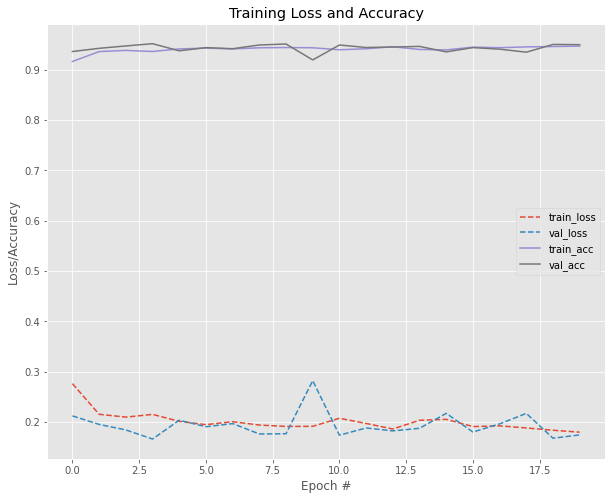

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
fig, ax = plt.subplots(1,1,figsize=(10,8))

ax.plot(np.arange(0, 20), history.history["loss"], label="train_loss",linestyle='--')
ax.plot(np.arange(0, 20), history.history["val_loss"], label="val_loss",linestyle='--')
ax.plot(np.arange(0, 20), history.history["accuracy"], label="train_acc")
ax.plot(np.arange(0, 20), history.history["val_accuracy"], label="val_acc")

ax.set_title("Training Loss and Accuracy")
ax.set_xlabel("Epoch #")
ax.set_ylabel("Loss/Accuracy")

ax.legend()
plt.show()

In [ ]:
print("[INFO] {} kWh of electricity used since the begining".format(tracker.final_emissions_data.energy_consumed))
print("[INFO] Energy consumed for RAM: {} kWh".format(tracker.final_emissions_data.ram_energy))
print("[INFO] Energy consumed for all GPU: {} kWh".format(tracker.final_emissions_data.gpu_energy))
print("[INFO] Energy consumed for all CPU: {} kWh".format(tracker.final_emissions_data.cpu_energy))
print("[INFO] CO2 emission {}(in Kg)".format(tracker.final_emissions_data.emissions))

[INFO] 0.003090903754561679 kWh of electricity used since the begining
[INFO] Energy consumed for RAM: 0.00018879389956189755 kWh
[INFO] Energy consumed for all GPU: 0.0012138577465384535 kWh
[INFO] Energy consumed for all CPU: 0.001688252108461327 kWh
[INFO] CO2 emission 0.0019503082289082784(in Kg)


**Evaluate the Network**

In [ ]:
print("[INFO] evaluating network...")
predictions = model.predict(test_x, batch_size=32)
print(classification_report(test_y.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=[str(i) for i in lb.classes_]))

[INFO] evaluating network...
313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.96      0.99      0.98      1135
           2       0.93      0.97      0.95      1032
           3       0.96      0.94      0.95      1010
           4       0.94      0.94      0.94       982
           5       0.95      0.95      0.95       892
           6       0.96      0.98      0.97       958
           7       0.98      0.91      0.94      1028
           8       0.95      0.92      0.94       974
           9       0.91      0.92      0.92      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



**Confusion Matrix**

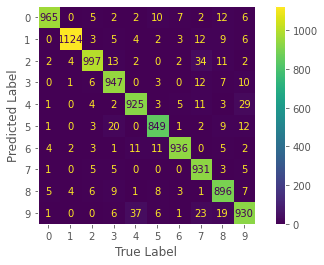

In [ ]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(predictions.argmax(axis=1),
                                        test_y.argmax(axis=1)),
                       display_labels=lb.classes_).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
ax.grid(False)
plt.show()

In [ ]:
# Uploading figures to W&B
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)

03-11-2022 00:18:40 Uploading figures


In [ ]:
# Evaluation Metrics
logger.info("Validation Evaluation metrics")
fbeta = fbeta_score(test_y.argmax(axis=1), 
                    predictions.argmax(axis=1), 
                    beta=1, zero_division=1,average='weighted')
precision = precision_score(test_y.argmax(axis=1),
                            predictions.argmax(axis=1),
                            zero_division=1,average='weighted')
recall = recall_score(test_y.argmax(axis=1),
                      predictions.argmax(axis=1),
                      zero_division=1,average='weighted')
acc = accuracy_score(test_y.argmax(axis=1),
                     predictions.argmax(axis=1))

logger.info("Validation Accuracy: {}".format(acc))
logger.info("Validation Precision: {}".format(precision))
logger.info("Validation Recall: {}".format(recall))
logger.info("Validation F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta
# number of parameters
run.summary["Count_Params"] = model.count_params()
# energy unit is kWh
run.summary["Energy_Consumed"] = tracker.final_emissions_data.energy_consumed
run.summary["Energy_RAM"] = tracker.final_emissions_data.ram_energy
run.summary["Energy_GPU"] = tracker.final_emissions_data.gpu_energy
run.summary["Energy_CPU"] = tracker.final_emissions_data.cpu_energy
# kg
run.summary["CO2_Emissions"] = tracker.final_emissions_data.emissions

03-11-2022 00:18:48 Validation Evaluation metrics
03-11-2022 00:18:48 Validation Accuracy: 0.95
03-11-2022 00:18:48 Validation Precision: 0.9503128302234857
03-11-2022 00:18:48 Validation Recall: 0.95
03-11-2022 00:18:48 Validation F1: 0.9498777559017514


In [ ]:
run.finish()

accuracy,▁▆▆▆▇▇▇▇▇▇▆▇█▆▆█▇███
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▃▄▃▂▃▂▂▂▃▂▁▃▃▂▂▂▁▁
val_accuracy,▅▆▇█▅▆▆▇█▁▇▆▇▇▄▆▆▄██
val_loss,▄▃▂▁▃▂▃▂▂█▁▂▂▂▄▂▃▄▁▁
Acc,0.95
CO2_Emissions,0.00195
Count_Params,61706
Energy_CPU,0.00169
Energy_Consumed,0.00309
Energy_GPU,0.00121


## Step 04: **Hyperparameter** tuning with **W&B Sweep**

**Define sweep Configuration:**

In [ ]:
# Configure the sweep 
sweep_config = {
    'method': 'random', 
    'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'conv_layer': { 'max': 3, 'min': 1, 'distribution': 'int_uniform', },
        'filters': { 'values': [4, 6, 12, 16] },
        'padding': { 'values': ['same', 'valid'] },
        'learn_rate': { 'values': [0.01, 0.001, 0.005] },
        'epochs': { 'values': [10, 20, 30] },
        'batch_size': { 'values': [32,64] }
    }
}

Initialize a new sweep
Arguments:

* sweep_config: the sweep config dictionary defined above
* entity: Set the username for the sweep
* project: Set the project name for the sweep

In [ ]:
sweep_id = wandb.sweep(sweep_config,
                       entity="euripedes",
                       project=args["project_name"])

Create sweep with ID: 65u9f59p
Sweep URL: https://wandb.ai/euripedes/lenet-5/sweeps/65u9f59p


**Adapting the model**

In [ ]:
class LeNetAdapt:
  @staticmethod
  def build(width, height, depth, classes, config):
    '''
      width, height, depth: dimensions of the image
      classes: number of targets
      config: variable used to configure the sweep
    '''
    # initialize the model
    model = Sequential()
    inputShape = (height, width, depth)
    
    # if we are using "channels first", update the input shape
    if K.image_data_format() == "channels_first":
      inputShape = (depth, height, width)
   

    # first set of CONV => TANH => POOL layers
    for i in range(config.conv_layer):
      model.add(Conv2D(config.filters, (5,5), strides=1, padding=config.padding,
                      activation='tanh', input_shape=inputShape ))
      model.add(AveragePooling2D())

    # a flatten and two set of FC => TANH layers
    model.add(Flatten()) #Flatten
    model.add(Dense(120, activation='tanh')) 
    model.add(Dense(84, activation='tanh')) 

    # softmax classifier
    model.add(Dense(10, activation='softmax')) #Output layer
    
    # return the constructed network architecture
    return model

**Training**

In [ ]:
def train():
    with wandb.init() as run:

      # create codecarbon tracker
      # codecarbon is too much verbose, change the log level for more info
      tracker = EmissionsTracker(log_level="critical")
      tracker.start()

      # initialize the optimizer and model
      print("[INFO] compiling model...")
      opt = Adam(learning_rate=run.config.learn_rate)
      model = LeNetAdapt.build(width=28, height=28,depth=1, classes=10, config=run.config)
      model.compile(loss="categorical_crossentropy", 
                    optimizer=opt,
                    metrics=["accuracy"]
                    )

      # train the network
      print("[INFO] training network...")
      history = model.fit(train_x, train_y, 
                    validation_data=(test_x, test_y),
                    batch_size=run.config.batch_size, 
                    epochs=run.config.epochs, 
                    verbose=0,
                    callbacks=[wandb.keras.WandbCallback(save_model=False,
                                                        compute_flops=True)]
                )

      # get co2 emissions from tracker
      # "CO2 emission (in Kg)"
      emissions = tracker.stop()

      # make predictions
      predictions = model.predict(test_x, batch_size=run.config.batch_size)

      # Evaluation Metrics
      logger.info("Validation Evaluation metrics")
      fbeta = fbeta_score(test_y.argmax(axis=1), 
                          predictions.argmax(axis=1), 
                          beta=1, zero_division=1,average='weighted')
      precision = precision_score(test_y.argmax(axis=1),
                                  predictions.argmax(axis=1),
                                  zero_division=1,average='weighted')
      recall = recall_score(test_y.argmax(axis=1),
                            predictions.argmax(axis=1),
                            zero_division=1,average='weighted')
      acc = accuracy_score(test_y.argmax(axis=1),
                          predictions.argmax(axis=1))

      logger.info("Validation Accuracy: {}".format(acc))
      logger.info("Validation Precision: {}".format(precision))
      logger.info("Validation Recall: {}".format(recall))
      logger.info("Validation F1: {}".format(fbeta))

      run.summary["Acc"] = acc
      run.summary["Precision"] = precision
      run.summary["Recall"] = recall
      run.summary["F1"] = fbeta
      # number of parameters
      run.summary["Count_Params"] = model.count_params()
      # energy unit is kWh
      run.summary["Energy_Consumed"] = tracker.final_emissions_data.energy_consumed
      run.summary["Energy_RAM"] = tracker.final_emissions_data.ram_energy
      run.summary["Energy_GPU"] = tracker.final_emissions_data.gpu_energy
      run.summary["Energy_CPU"] = tracker.final_emissions_data.cpu_energy
      # kg
      run.summary["CO2_Emissions"] = tracker.final_emissions_data.emissions

      run.finish()

In [ ]:
wandb.agent(sweep_id=sweep_id, function=train, count=10)

wandb: Agent Starting Run: viab59a8 with config:
wandb: 	batch_size: 64
wandb: 	conv_layer: 2
wandb: 	epochs: 20
wandb: 	filters: 12
wandb: 	learn_rate: 0.001
wandb: 	padding: same
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


[INFO] compiling model...
[INFO] training network...
157/157 [==============================] - 0s 2ms/step


03-11-2022 00:25:26 Validation Evaluation metrics
03-11-2022 00:25:26 Validation Accuracy: 0.9868
03-11-2022 00:25:26 Validation Precision: 0.9868172935214178
03-11-2022 00:25:26 Validation Recall: 0.9868
03-11-2022 00:25:26 Validation F1: 0.9867955510063293


accuracy,▁▅▆▇▇▇▇▇████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▆▆▇▇▇▇▇▇█▇▇▆██▇▇▇█
val_loss,█▅▃▂▁▁▂▁▁▁▁▁▂▃▁▁▂▂▂▂
Acc,0.9868
CO2_Emissions,0.00121
Count_Params,85618
Energy_CPU,0.00098
Energy_Consumed,0.00191
Energy_GPU,0.00082


wandb: Agent Starting Run: mrzf1rjp with config:
wandb: 	batch_size: 64
wandb: 	conv_layer: 3
wandb: 	epochs: 10
wandb: 	filters: 16
wandb: 	learn_rate: 0.005
wandb: 	padding: same
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


[INFO] compiling model...
[INFO] training network...
157/157 [==============================] - 0s 2ms/step


03-11-2022 00:26:31 Validation Evaluation metrics
03-11-2022 00:26:31 Validation Accuracy: 0.981
03-11-2022 00:26:31 Validation Precision: 0.9810531933452643
03-11-2022 00:26:31 Validation Recall: 0.981
03-11-2022 00:26:31 Validation F1: 0.9809980407496525


accuracy,▁▇▇███████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▂▁▁▁▁▁▁▁
val_accuracy,▁▂▆▆▇▅█▆▅▇
val_loss,█▆▃▃▂▃▁▂▃▂
Acc,0.981
CO2_Emissions,0.00064
Count_Params,41662
Energy_CPU,0.0005
Energy_Consumed,0.00102
Energy_GPU,0.00046


wandb: Agent Starting Run: fa6mjwq1 with config:
wandb: 	batch_size: 32
wandb: 	conv_layer: 1
wandb: 	epochs: 20
wandb: 	filters: 12
wandb: 	learn_rate: 0.005
wandb: 	padding: same
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


[INFO] compiling model...
[INFO] training network...
313/313 [==============================] - 1s 2ms/step


03-11-2022 00:28:54 Validation Evaluation metrics
03-11-2022 00:28:54 Validation Accuracy: 0.9531
03-11-2022 00:28:54 Validation Precision: 0.9539208978694118
03-11-2022 00:28:54 Validation Recall: 0.9531
03-11-2022 00:28:54 Validation F1: 0.9531864706493807


accuracy,▁▄▅▅▆▆▆▇▇▇▇▇▇█▇▇▇▇██
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▄▄▃▃▃▃▂▂▂▂▂▁▂▂▂▂▂▁
val_accuracy,▁▄▅▆▇▆▆▆▆▇▇▆▇▇▇▇▆█▆▇
val_loss,█▅▄▄▃▃▃▄▃▃▃▃▃▂▃▃▄▁▃▃
Acc,0.9531
CO2_Emissions,0.00174
Count_Params,293686
Energy_CPU,0.00144
Energy_Consumed,0.00275
Energy_GPU,0.00115


wandb: Agent Starting Run: 5tw12ekw with config:
wandb: 	batch_size: 32
wandb: 	conv_layer: 1
wandb: 	epochs: 20
wandb: 	filters: 16
wandb: 	learn_rate: 0.005
wandb: 	padding: valid
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


[INFO] compiling model...
[INFO] training network...
313/313 [==============================] - 1s 2ms/step


03-11-2022 00:31:38 Validation Evaluation metrics
03-11-2022 00:31:38 Validation Accuracy: 0.9539
03-11-2022 00:31:38 Validation Precision: 0.9542402152784399
03-11-2022 00:31:38 Validation Recall: 0.9539
03-11-2022 00:31:38 Validation F1: 0.9539273551990601


accuracy,▁▅▅▅▆▆▆▆▇▆▆▇▇▇█▇██▇█
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▄▄▃▃▃▃▂▃▃▂▂▂▁▂▁▁▂▁
val_accuracy,▂▃▁▅▅▆▃▄▆▄▇▆▃█▇▇▇▇▆▇
val_loss,█▇█▄▄▄▆▅▃▅▂▃▅▁▂▂▂▂▃▁
Acc,0.9539
CO2_Emissions,0.002
Count_Params,288030
Energy_CPU,0.00168
Energy_Consumed,0.00317
Energy_GPU,0.0013


wandb: Agent Starting Run: qf5iwub7 with config:
wandb: 	batch_size: 64
wandb: 	conv_layer: 2
wandb: 	epochs: 10
wandb: 	filters: 16
wandb: 	learn_rate: 0.001
wandb: 	padding: valid
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


[INFO] compiling model...
[INFO] training network...
157/157 [==============================] - 0s 2ms/step


03-11-2022 00:32:38 Validation Evaluation metrics
03-11-2022 00:32:38 Validation Accuracy: 0.9866
03-11-2022 00:32:38 Validation Precision: 0.9866522863472253
03-11-2022 00:32:38 Validation Recall: 0.9866
03-11-2022 00:32:38 Validation F1: 0.9865996287393566


accuracy,▁▆▇▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▅▇▆█▇████
val_loss,█▄▂▃▁▂▁▁▁▁
Acc,0.9866
CO2_Emissions,0.00011
Count_Params,48686
Energy_CPU,0.00045
Energy_Consumed,0.00085
Energy_GPU,0.00036


wandb: Agent Starting Run: 8hhdq803 with config:
wandb: 	batch_size: 32
wandb: 	conv_layer: 1
wandb: 	epochs: 10
wandb: 	filters: 16
wandb: 	learn_rate: 0.005
wandb: 	padding: valid
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


[INFO] compiling model...
[INFO] training network...
313/313 [==============================] - 1s 2ms/step


03-11-2022 00:34:20 Validation Evaluation metrics
03-11-2022 00:34:20 Validation Accuracy: 0.9519
03-11-2022 00:34:20 Validation Precision: 0.9523347439942087
03-11-2022 00:34:20 Validation Recall: 0.9519
03-11-2022 00:34:20 Validation F1: 0.9518435241043793


accuracy,▁▄▆▆▆▇▆▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▃▃▂▃▂▁▁
val_accuracy,▁▃▁▅▇▆▅▆█▇
val_loss,█▇▇▄▂▃▄▃▁▂
Acc,0.9519
CO2_Emissions,0.00118
Count_Params,288030
Energy_CPU,0.00098
Energy_Consumed,0.00186
Energy_GPU,0.00078


wandb: Agent Starting Run: mf6vgofp with config:
wandb: 	batch_size: 32
wandb: 	conv_layer: 2
wandb: 	epochs: 30
wandb: 	filters: 4
wandb: 	learn_rate: 0.01
wandb: 	padding: valid
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


[INFO] compiling model...
[INFO] training network...
313/313 [==============================] - 1s 2ms/step


03-11-2022 00:37:40 Validation Evaluation metrics
03-11-2022 00:37:40 Validation Accuracy: 0.9604
03-11-2022 00:37:40 Validation Precision: 0.9605948901048404
03-11-2022 00:37:40 Validation Recall: 0.9604
03-11-2022 00:37:40 Validation F1: 0.9604366079338735


accuracy,▁▅▆▇▇█▇▇███▇▇▇████▇██████▇▆███
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▄▃▂▂▂▂▁▁▁▁▂▂▂▁▁▂▂▂▁▁▂▁▁▁▂▃▁▁▂
val_accuracy,▁▄▄▆▆▆▆▆█▃▅▅▅▇▇▆▇▄▅▇▆▇▇▆▃▆▄▅▆▆
val_loss,█▅▆▃▅▂▄▄▁▇▅▅▄▂▂▃▂▇▄▂▂▃▂▃▇▃▆▄▃▅
Acc,0.9604
CO2_Emissions,0.00251
Count_Params,19322
Energy_CPU,0.00209
Energy_Consumed,0.00397
Energy_GPU,0.00165


wandb: Agent Starting Run: jyhf6swb with config:
wandb: 	batch_size: 64
wandb: 	conv_layer: 2
wandb: 	epochs: 30
wandb: 	filters: 6
wandb: 	learn_rate: 0.001
wandb: 	padding: same
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


[INFO] compiling model...
[INFO] training network...
157/157 [==============================] - 0s 2ms/step


03-11-2022 00:39:54 Validation Evaluation metrics
03-11-2022 00:39:54 Validation Accuracy: 0.9877
03-11-2022 00:39:54 Validation Precision: 0.987717083373606
03-11-2022 00:39:54 Validation Recall: 0.9877
03-11-2022 00:39:54 Validation F1: 0.9876944740487795


accuracy,▁▅▆▇▇▇▇▇▇█████████████████████
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▆▇▆▆▇▇▇▇▇▇▇█▇▇▇▇▇▇█▇▇▇█▇██▇█
val_loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▂▁▂▁▂▁▂▂▂▂▂▂▂▂▂
Acc,0.9877
CO2_Emissions,0.00162
Count_Params,47476
Energy_CPU,0.00131
Energy_Consumed,0.00256
Energy_GPU,0.0011


wandb: Agent Starting Run: ipqiroqx with config:
wandb: 	batch_size: 32
wandb: 	conv_layer: 1
wandb: 	epochs: 30
wandb: 	filters: 16
wandb: 	learn_rate: 0.001
wandb: 	padding: valid
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


[INFO] compiling model...
[INFO] training network...
313/313 [==============================] - 1s 2ms/step


03-11-2022 00:43:38 Validation Evaluation metrics
03-11-2022 00:43:38 Validation Accuracy: 0.9806
03-11-2022 00:43:38 Validation Precision: 0.9806232267216619
03-11-2022 00:43:38 Validation Recall: 0.9806
03-11-2022 00:43:38 Validation F1: 0.980590165612071


accuracy,▁▅▆▆▆▇▇▇▇▇▇▇▇█████████████████
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▄▄▅▅▆▆▆▅▆▇▇▆█▇▇▇▇█▇▇▇▇▇▇██▇█
val_loss,█▄▃▄▃▂▂▂▂▄▂▂▃▂▁▂▃▁▃▁▃▂▄▃▂▂▃▂▄▂
Acc,0.9806
CO2_Emissions,0.0029
Count_Params,288030
Energy_CPU,0.00239
Energy_Consumed,0.00459
Energy_GPU,0.00193


wandb: Agent Starting Run: m8m4o5vn with config:
wandb: 	batch_size: 64
wandb: 	conv_layer: 3
wandb: 	epochs: 20
wandb: 	filters: 12
wandb: 	learn_rate: 0.005
wandb: 	padding: valid
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


[INFO] compiling model...


Run m8m4o5vn errored: ValueError('Exception encountered when calling layer "conv2d_2" (type Conv2D).\n\nNegative dimension size caused by subtracting 5 from 4 for \'{{node conv2d_2/Conv2D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](Placeholder, conv2d_2/Conv2D/ReadVariableOp)\' with input shapes: [?,4,4,12], [5,5,12,12].\n\nCall arguments received by layer "conv2d_2" (type Conv2D):\n  • inputs=tf.Tensor(shape=(None, 4, 4, 12), dtype=float32)')
wandb: ERROR Run m8m4o5vn errored: ValueError('Exception encountered when calling layer "conv2d_2" (type Conv2D).\n\nNegative dimension size caused by subtracting 5 from 4 for \'{{node conv2d_2/Conv2D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](Placeholder, conv2d_2/Conv2D/ReadVariableOp)\' with input shapes: [?,4,4,12], [5,5,12,12].\n\

In [ ]:
run.finish()

## Step 05: Train and Export the best model to W&B

With the results of Sweeps we know which configuration is the best and now we need to save it in our W&B project.

* It's important to understand that since we used the "random" method from WandB this model its not necessarily the best possible, it means that it was the best from all the combinations formed during the hyperparameter tuning process.  

Speak of it, that's the best configuration that Sweeps showed us:

* batch_size: 64
* conv_layer: 2
* epochs: 30
* filters: 6
* learn_rate: 0.001
* padding: same

### Creating the Best Model

In [ ]:
args = {
  "project_name": "lenet-5",
  "encoder": "target_encoder"
}

In [ ]:
run = wandb.init(entity="euripedes",
                 project=args["project_name"], 
                 job_type="Final_model")

wandb: Currently logged in as: euripedes. Use `wandb login --relogin` to force relogin


### Fetch, Preprocessing and Data Segregation

***Run the same process we did before!***

### Training

In [ ]:
class UpdatedLeNet:
  @staticmethod
  def build(width, height, depth, classes):
    # initialize the model
    model = Sequential()
    inputShape = (height, width, depth)
    
    # if we are using "channels first", update the input shape
    if K.image_data_format() == "channels_first":
      inputShape = (depth, height, width)
   
    # first set of CONV => TANH => POOL layers
    for i in range(2):
      model.add(Conv2D(6, (5, 5), strides=1, padding='same',
                      activation='tanh', input_shape=(28,28,1), ))
      model.add(AveragePooling2D()) 

    # a flatten and two set of FC => TANH layers
    model.add(Flatten()) #Flatten
    model.add(Dense(120, activation='tanh'))
    model.add(Dense(84, activation='tanh'))

    # softmax classifier
    model.add(Dense(10, activation='softmax')) #Output layer
    
    # return the constructed network architecture
    return model

In [ ]:
# create codecarbon tracker
# codecarbon is too much verbose, change the log level for more info
tracker = EmissionsTracker(log_level="critical")
tracker.start()

# initialize the optimizer and model
logger.info("[INFO] compiling model...")
opt = Adam(learning_rate=0.001)
model = UpdatedLeNet.build(width=28, height=28, depth=1, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])

# train the network
logger.info("[INFO] training network...")
history = model.fit(train_x, train_y,
              validation_data=(test_x, test_y),
              batch_size=64,
              epochs=30, 
              verbose=0,
              callbacks=[wandb.keras.WandbCallback(save_model=False,
                                                   compute_flops=True)])

# get co2 emissions from tracker
# "CO2 emission (in Kg)"
emissions = tracker.stop()

03-11-2022 01:14:02 [INFO] compiling model...
03-11-2022 01:14:05 [INFO] training network...
03-11-2022 01:14:06 From /usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/nn_ops.py:5219: tensor_shape_from_node_def_name (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


### Evaluation Metrics

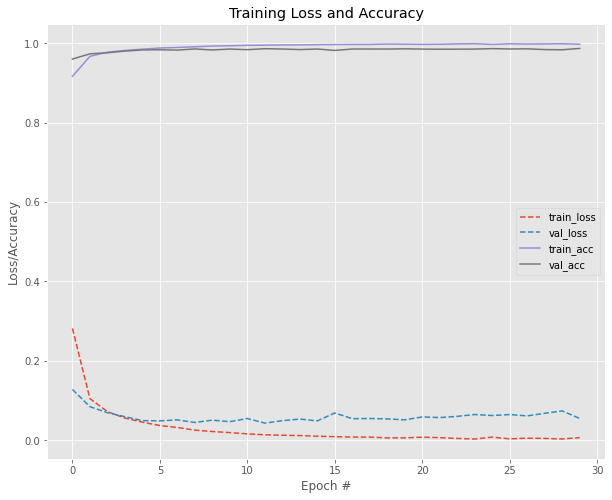

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
fig, ax = plt.subplots(1,1,figsize=(10,8))

ax.plot(np.arange(0, 30), history.history["loss"], label="train_loss",linestyle='--')
ax.plot(np.arange(0, 30), history.history["val_loss"], label="val_loss",linestyle='--')
ax.plot(np.arange(0, 30), history.history["accuracy"], label="train_acc")
ax.plot(np.arange(0, 30), history.history["val_accuracy"], label="val_acc")
ax.set_title("Training Loss and Accuracy")
ax.set_xlabel("Epoch #")
ax.set_ylabel("Loss/Accuracy")
ax.legend()
plt.show()

In [ ]:
print("[INFO] {} kWh of electricity used since the begining".format(tracker.final_emissions_data.energy_consumed))
print("[INFO] Energy consumed for RAM: {} kWh".format(tracker.final_emissions_data.ram_energy))
print("[INFO] Energy consumed for all GPU: {} kWh".format(tracker.final_emissions_data.gpu_energy))
print("[INFO] Energy consumed for all CPU: {} kWh".format(tracker.final_emissions_data.cpu_energy))
print("[INFO] CO2 emission {}(in Kg)".format(tracker.final_emissions_data.emissions))


[INFO] 0.002535853084691442 kWh of electricity used since the begining
[INFO] Energy consumed for RAM: 0.00015756010619515527 kWh
[INFO] Energy consumed for all GPU: 0.0009692661255839136 kWh
[INFO] Energy consumed for all CPU: 0.001409026852912373 kWh
[INFO] CO2 emission 0.0011477797888429745(in Kg)


In [ ]:
print("[INFO] evaluating network...")
predictions = model.predict(test_x, batch_size=32)
print(classification_report(test_y.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=[str(i) for i in lb.classes_]))

[INFO] evaluating network...
313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.98      0.99      0.98      1010
           4       0.99      0.99      0.99       982
           5       0.98      0.99      0.99       892
           6       0.99      0.98      0.99       958
           7       0.99      0.98      0.99      1028
           8       0.99      0.98      0.99       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



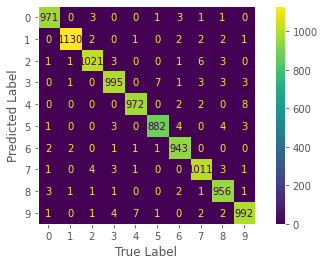

In [ ]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(predictions.argmax(axis=1),
                                        test_y.argmax(axis=1)),
                       display_labels=lb.classes_).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
ax.grid(False)
plt.show()

Uploading the figures

In [ ]:
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)

03-11-2022 01:19:12 Uploading figures


In [ ]:
# Evaluation Metrics
logger.info("Validation Evaluation metrics")
fbeta = fbeta_score(test_y.argmax(axis=1), 
                    predictions.argmax(axis=1), 
                    beta=1, zero_division=1,average='weighted')
precision = precision_score(test_y.argmax(axis=1),
                            predictions.argmax(axis=1),
                            zero_division=1,average='weighted')
recall = recall_score(test_y.argmax(axis=1),
                      predictions.argmax(axis=1),
                      zero_division=1,average='weighted')
acc = accuracy_score(test_y.argmax(axis=1),
                     predictions.argmax(axis=1))

logger.info("Validation Accuracy: {}".format(acc))
logger.info("Validation Precision: {}".format(precision))
logger.info("Validation Recall: {}".format(recall))
logger.info("Validation F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta
# number of parameters
run.summary["Count_Params"] = model.count_params()
# energy unit is kWh
run.summary["Energy_Consumed"] = tracker.final_emissions_data.energy_consumed
run.summary["Energy_RAM"] = tracker.final_emissions_data.ram_energy
run.summary["Energy_GPU"] = tracker.final_emissions_data.gpu_energy
run.summary["Energy_CPU"] = tracker.final_emissions_data.cpu_energy
# kg
run.summary["CO2_Emissions"] = tracker.final_emissions_data.emissions

03-11-2022 01:19:33 Validation Evaluation metrics
03-11-2022 01:19:33 Validation Accuracy: 0.9873
03-11-2022 01:19:33 Validation Precision: 0.9873088361428725
03-11-2022 01:19:33 Validation Recall: 0.9873
03-11-2022 01:19:33 Validation F1: 0.987298779748653


Now we can finish our process! ✅

In [ ]:
run.finish()

accuracy,▁▅▆▇▇▇▇▇▇█████████████████████
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▆▇▇▇█▇█▇██▇█▇█████▇█████▇▇█
val_loss,█▄▃▂▂▁▂▁▂▁▂▁▂▂▁▃▂▂▂▂▂▂▂▃▃▃▃▃▄▂
Acc,0.9873
CO2_Emissions,0.00115
Count_Params,47476
Energy_CPU,0.00141
Energy_Consumed,0.00254
Energy_GPU,0.00097
